# MODELOS

En el siguiente notebook se prueban y se hace el ajuste de hiperparametros de distintos modelos de clasificacion binaria, para la prediccion de la condicion de un producto

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Lectura de insumos

en esta seccion se hace la lectura de las variables predictivas y variables objetivo para los set de entrenamiento y pruebas, las variables a utilizar en el modelo son leidas a partir de las transformaciones realizadas en el notebook *02_data_transformation*

In [44]:
# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open("../data/MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

In [46]:
X_train, y_train, X_test, y_test = build_dataset()
del(X_train,X_test)

Transformaciones finales

In [125]:
df_X_train_processed = pd.read_csv("X_train_processed.csv")
df_X_test_processed = pd.read_csv("X_test_processed.csv")
y_train_transform = [int(x == "used") for x in y_train]
y_test_transform = [int(x == "used") for x in y_test]

## Desarrollo de modelos 

Se seleccionan tres tipos de modelos para probar, los modelos elegidos son principalmente por su popularidad, e interpretabilidad de resutlados

- Regresion Logistica
- RandomForest
- XGBoost: 
Se emplean dos librerias la primera de *sklearn* y la segunda *xgboost* [link](https://xgboost.readthedocs.io/en/stable/) la cual tiene mejor desempeño que la de sklearn en general

Para cada modelo primero se creara un modelo base, el cual es entrenado con los valores estandar de hiperparametros definidos en las librerias, luego se tratará de mejorar el desempeño del modelo iterando por disitntos valores y configuraciones de hiperparametros.

Para iterar entre los hiperparametros se empleara:
- GridSearch: da un resultado mas robusto ya que no solo itera por los distintos valoresde hiperparametros si no que calcula las metricas de desempeño en distintos *"folds"* de los datos. Estos benedicios se dan en contraposicion a un tiempo mayor de ejecucion.


In [7]:
#pip install xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [70]:
dict_accuracy_models = {}

### Regresion Logistica

Se tomara como linea base el resultado de este modelo, para asi poder comparar el resto de modelos y ajuste de hiperparametros

Accuracy: 0.8562


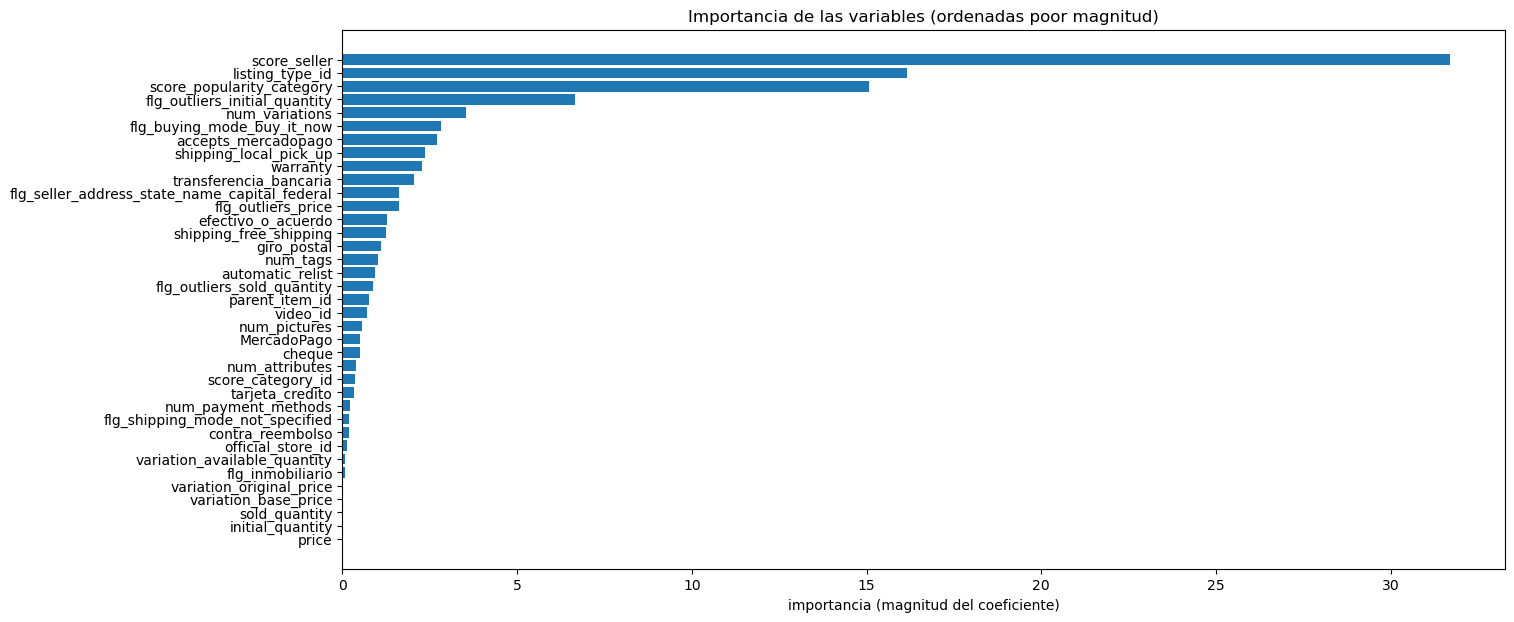

In [126]:
logi = LogisticRegression(max_iter=1000, random_state=42)
logi.fit(df_X_train_processed, y_train_transform)
y_pred = logi.predict(df_X_test_processed)

# Calculate accuracy
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["reg_log_base"] = accuracy
print(f'Accuracy: {accuracy:.4f}')

feature_importance = logi.coef_[0]
absolute_importance = np.abs(feature_importance)
importance_percentage = (absolute_importance / absolute_importance.sum()) * 100

sorted_indices = np.argsort(np.abs(importance_percentage ))[::]
sorted_features = [df_X_train_processed.columns.values[i] for i in sorted_indices]
sorted_importance = importance_percentage[sorted_indices]

# Create a bar plot for sorted feature importance
plt.figure(figsize=(15, 7))
plt.barh(sorted_features, sorted_importance)
plt.xlabel('importancia (magnitud del coeficiente)')
plt.title('Importancia de las variables (ordenadas poor magnitud)')
plt.show()

#### Ajuste Hiperparametros

Para esta variable 

In [116]:
parameters = {
    'max_iter': [100,1000],
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],  
    'solver': ['liblinear']         
}

log_grd = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=parameters,
    verbose=3 
)

log_grd.fit(df_X_train_processed.drop(columns=["score_seller"]),y_train_transform)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.1, max_iter=100, penalty=l1, solver=liblinear;, score=0.884 total time=   0.1s
[CV 2/5] END C=0.1, max_iter=100, penalty=l1, solver=liblinear;, score=0.882 total time=   0.1s
[CV 3/5] END C=0.1, max_iter=100, penalty=l1, solver=liblinear;, score=0.882 total time=   0.1s
[CV 4/5] END C=0.1, max_iter=100, penalty=l1, solver=liblinear;, score=0.885 total time=   1.4s


c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=0.1, max_iter=100, penalty=l1, solver=liblinear;, score=0.883 total time=  15.8s
[CV 1/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.852 total time=   0.4s
[CV 2/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.857 total time=   1.0s
[CV 3/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.551 total time=   0.3s
[CV 4/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.853 total time=   0.5s
[CV 5/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.769 total time=   0.3s
[CV 1/5] END C=0.1, max_iter=1000, penalty=l1, solver=liblinear;, score=0.884 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=1000, penalty=l1, solver=liblinear;, score=0.882 total time=   0.1s
[CV 3/5] END C=0.1, max_iter=1000, penalty=l1, solver=liblinear;, score=0.882 total time=   0.1s
[CV 4/5] END C=0.1, max_iter=1000, penalty=l1, solver=liblinear;, score=0.885 total time=   1.3s
[CV 5/5] END C=0.1, max_iter=1000, p

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=10, max_iter=100, penalty=l1, solver=liblinear;, score=0.882 total time=  29.2s
[CV 1/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.864 total time=   0.8s
[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.836 total time=   0.7s
[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.551 total time=   0.2s
[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.853 total time=   0.5s
[CV 5/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.769 total time=   0.3s
[CV 1/5] END C=10, max_iter=1000, penalty=l1, solver=liblinear;, score=0.884 total time=   0.0s
[CV 2/5] END C=10, max_iter=1000, penalty=l1, solver=liblinear;, score=0.883 total time=   7.8s
[CV 3/5] END C=10, max_iter=1000, penalty=l1, solver=liblinear;, score=0.882 total time=   0.1s
[CV 4/5] END C=10, max_iter=1000, penalty=l1, solver=liblinear;, score=0.885 total time=   0.5s
[CV 5/5] END C=10, max_iter=1000, penalty=l1, 

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'max_iter': [100, 1000],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=3)

In [117]:
print("mejores hiperparametros:")
display(pd.DataFrame([log_grd.best_params_]))

y_pred = log_grd.best_estimator_.predict(df_X_test_processed.drop(columns="score_seller"))
accuracy = accuracy_score(y_test_transform, y_pred)

print(f"accuracy score train: {log_grd.best_score_}")
print(f"accuracy score test: {accuracy}")

mejores hiperparametros:


,C,max_iter,penalty,solver
0,0.1,100,l1,liblinear


accuracy score train: 0.8832555555555555
accuracy score test: 0.8464


Accuracy: 0.8182


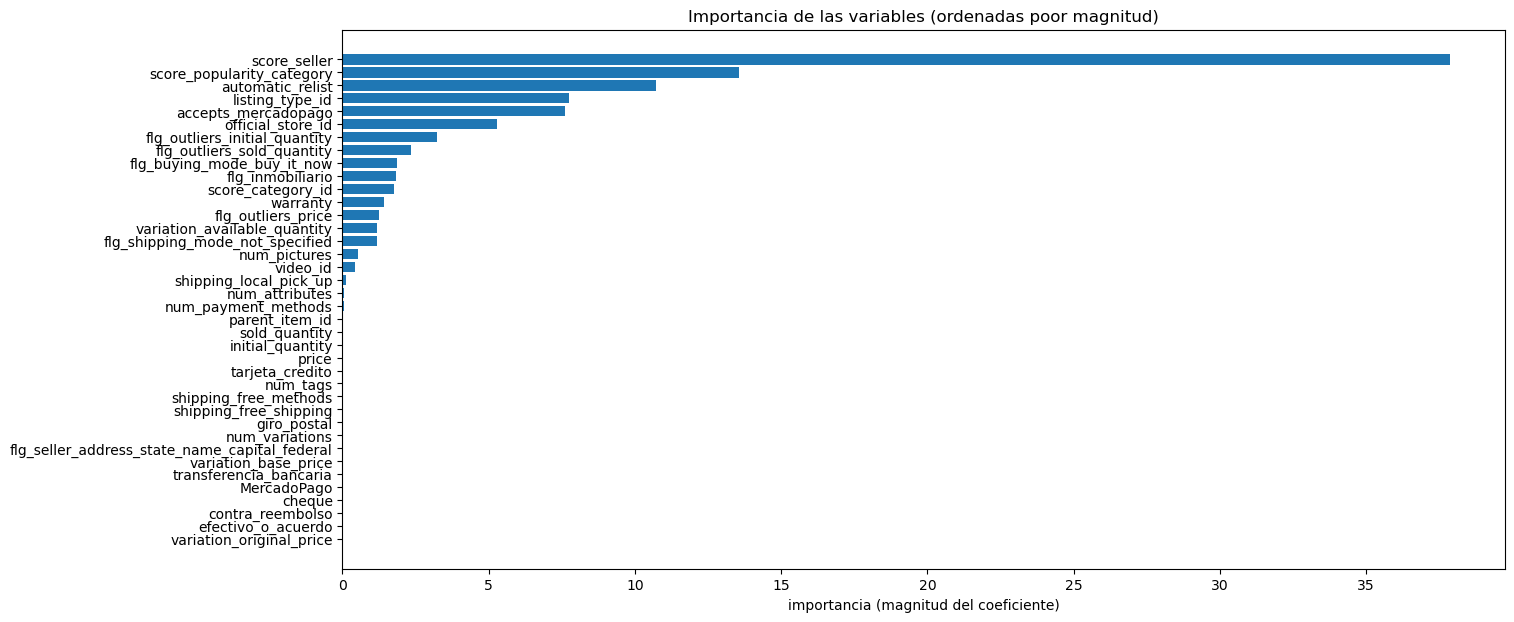

In [124]:
logi = LogisticRegression(random_state=42, max_iter=100, penalty="l1", solver="liblinear", C=0.1)
logi.fit(df_X_train_processed, y_train_transform)
y_pred = logi.predict(df_X_test_processed)

# Calculate accuracy
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["reg_log_ajustado"] = accuracy
print(f'Accuracy: {accuracy:.4f}')

feature_importance = logi.coef_[0]
absolute_importance = np.abs(feature_importance)
importance_percentage = (absolute_importance / absolute_importance.sum()) * 100

sorted_indices = np.argsort(np.abs(importance_percentage ))[::]
sorted_features = [df_X_train_processed.columns.values[i] for i in sorted_indices]
sorted_importance = importance_percentage[sorted_indices]

display

# Create a bar plot for sorted feature importance
plt.figure(figsize=(15, 7))
plt.barh(sorted_features, sorted_importance)
plt.xlabel('importancia (magnitud del coeficiente)')
plt.title('Importancia de las variables (ordenadas poor magnitud)')
plt.show()

### XGBoost


#### Modelo Base
para dar una idea del desempeño del modelo, se ejecuta el modelo estandar. 

- En este se evidencia que la variable **score_seller** tiene una importancia mayor al **95%** para la libreria de *sklearn* y superior al **72%** en la libreria *xgboost*, que esta variable tenga tanto peso nos indica que el modelo esta sesgado al valor de esta variable y ya que esta fue creada a partir de la proporcion de productos de la categoria usado que vende un usuario, se puede estar dando un fenomeno de <span style="color: red;"> data leakage </span> por lo que se decide probar nuevamente el modelo sin tener en cuenta esta variable. 

- Cuando se elimina la variable **score_seller** las metricas del modelo mejoran, dando un puntaje de 0.87. Por este motivo de ahora en adelante el ajuste de hiperparametros se realizara en el dataset sin esta variable

- Se determina que la libreria *xgboost* tiene un mejor desempeño que la libreria de *sklearn* por lo que el ajuste de hiperparametros se realizara unicamente con este modelo



- **libreria sklearn**

In [ ]:
test = GradientBoostingClassifier()
test.fit(df_X_train_processed, y_train_transform)
y_pred = test.predict(df_X_test_processed)
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["GB_sklearn_base"] = accuracy
print("accuracy score: {}".format(accuracy))

feature_importances = test.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

- **libreria xgboost**

In [ ]:
test = XGBClassifier()
test.fit(df_X_train_processed, y_train_transform)
y_pred = test.predict(df_X_test_processed)
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["GB_xgboost_base_score_seller"] = accuracy
print("accuracy score: {}".format(accuracy))

feature_importances = test.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8215


,Feature,Importance
32,score_seller,0.728126
1,listing_type_id,0.138286
33,score_popularity_category,0.017690
8,initial_quantity,0.011853
3,parent_item_id,0.010928
9,sold_quantity,0.009680
29,num_tags,0.007024
30,num_pictures,0.006498
10,shipping_local_pick_up,0.006111
2,price,0.005881


- **libreria sklearn sin score_seller**

In [ ]:
test = GradientBoostingClassifier()
test.fit(df_X_train_processed.drop(columns="score_seller"), y_train_transform)
y_pred = test.predict(df_X_test_processed.drop(columns="score_seller"))
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["GB_xgboost_base"] = accuracy
print("accuracy score: {}".format(accuracy))

feature_importances = test.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns="score_seller").columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8653


,Feature,Importance
32,score_popularity_category,0.652287
1,listing_type_id,0.186581
8,initial_quantity,0.113406
2,price,0.016328
9,sold_quantity,0.005076
36,flg_outliers_sold_quantity,0.004672
30,num_pictures,0.004488
33,score_category_id,0.003256
12,shipping_free_methods,0.002622
29,num_tags,0.001848


- **libreria sklearn - sin score seller**

In [ ]:
test = XGBClassifier()
test.fit(df_X_train_processed.drop(columns="score_seller"), y_train_transform)
y_pred = test.predict(df_X_test_processed.drop(columns="score_seller"))
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["GB_xgboost_base"] = accuracy
print("accuracy score: {}".format(accuracy))

feature_importances = test.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns="score_seller").columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8721


,Feature,Importance
32,score_popularity_category,0.252605
1,listing_type_id,0.231821
8,initial_quantity,0.128012
11,shipping_free_shipping,0.049634
12,shipping_free_methods,0.049149
9,sold_quantity,0.028372
20,MercadoPago,0.021770
0,warranty,0.019586
25,tarjeta_credito,0.017856
29,num_tags,0.016211


#### Ajuste Hiperparametros

resultado de analizar el modelo base el ajuste de hiperparametros solo se realizara sobre:
- modelo de la libreria xgboost
- modelo sin la variable score_seller

##### Grid Search

In [71]:
learning_rate = np.arange(0.41,0.71,0.1)
max_depth = np.arange(2,8,2)
n_estimators = np.arange(94,106,2)
lambda_values = np.arange(0,2,1)
alpha_values = np.arange(0,2,1)

parameters = {"n_estimators":n_estimators, 
              "max_depth":max_depth,
              "learning_rate":learning_rate,
              "reg_lambda": lambda_values,
              "reg_alpha":alpha_values
              }

clf = GridSearchCV(XGBClassifier(), parameters, verbose = 3)
clf.fit(df_X_train_processed.drop(columns=["score_seller"]),y_train_transform)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.903 total time=   0.1s
[CV 2/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.905 total time=   0.1s
[CV 3/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.903 total time=   0.1s
[CV 4/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.909 total time=   0.1s
[CV 5/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.905 total time=   0.1s
[CV 1/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=1;, score=0.904 total time=   0.1s
[CV 2/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=1;, score=0.906 total time=   0.1s
[CV 3/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_la

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': array([0.41, 0.51, 0.61]),
                         'max_depth': array([2, 4, 6]),
                         'n_estimators': array([ 94,  96,  98, 100, 102, 104]),
                         'reg_alpha': array([0, 1]),
                         'reg_lambda': array([0, 1])},
             verbose=3)

En la siguiente ceda se obtiene el mejor modelo despues de la busqueda por gridsearch, y ademas se muestran los resultados de la metrica de desempeño evaluada, que en este caso es accuracy.

Se ve que para el set de entrenamiento el accuracy es **0.91** mientras que para el set de pruebas es de **0,86** esta diferencia indica que puede existir un sobreajuste del modelo a pesar de haber realizado un entrenamiento con *folds*. Sin embargo a pesar de esto el modelo tiene un buen desempeño

In [ ]:
print("mejores hiperparametros:")
display(pd.DataFrame([clf.best_params_]))

y_pred = clf.best_estimator_.predict(df_X_test_processed.drop(columns="score_seller"))
accuracy = accuracy_score(y_test_transform, y_pred)

print(f"accuracy score train: {clf.best_score_}")
print(f"accuracy score test: {accuracy}")

mejores hiperparametros:


,learning_rate,max_depth,n_estimators,reg_alpha,reg_lambda
0,0.41,6,104,1,1


accuracy score train: 0.9116111111111109
accuracy score test: 0.8736


A continuacion se entrena el modelo con los mejores hiperparametros

In [ ]:
xg = XGBClassifier(learning_rate=0.41, max_depth=6,n_estimators=104,reg_lambda = 1, reg_alpha= 1)
xg.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)
y_pred = xg.predict(df_X_test_processed.drop(columns=["score_seller"]))

roc = roc_auc_score(y_test_transform, y_pred, average='macro')
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["GB_xgboost_ajustado"] = accuracy

print(f"area bajo la curva roc: {roc}")
print(f"accuracy score test: {accuracy}")

area bajo la curva roc: 0.8723360151759014
accuracy score test: 0.8736


In [92]:
feature_importances = xg.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns=["score_seller"]).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
importance_df.reset_index(drop=True, inplace=True)
importance_df.head(10)

,Feature,Importance
0,listing_type_id,0.268457
1,score_popularity_category,0.218792
2,initial_quantity,0.140751
3,shipping_free_shipping,0.042352
4,sold_quantity,0.026831
5,MercadoPago,0.026825
6,official_store_id,0.023559
7,giro_postal,0.019696
8,accepts_mercadopago,0.019077
9,warranty,0.017504


### Random Forest

#### Modelo Base
para dar una idea del desempeño del modelo, se ejecuta el modelo estandar. 

- En este se evidencia que la variable **score_seller** tiene una importancia mayor al **50%** inspirado en el modelo aterior, se decide eliminar esta variable del analisis para asi poder encontrar relaciones que generalicen mejor el problema

- Cuando se elimina la variable **score_seller** las metricas del modelo mejoran, dando un puntaje de **87%**

- **con score seller**

In [96]:
test = RandomForestClassifier(random_state=123)
test.fit(df_X_train_processed, y_train_transform)
y_pred = test.predict(df_X_test_processed)
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["RF_base_con_score"] = accuracy
print("accuracy score: {}".format(accuracy))

feature_importances = test.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8231


,Feature,Importance
32,score_seller,0.500166
33,score_popularity_category,0.183530
8,initial_quantity,0.074496
1,listing_type_id,0.070950
36,flg_outliers_initial_quantity,0.041100
2,price,0.031318
34,score_category_id,0.019224
37,flg_outliers_sold_quantity,0.016421
9,sold_quantity,0.012957
30,num_pictures,0.008391


- **sin score seller**

In [97]:
test = RandomForestClassifier(random_state=123)
test.fit(df_X_train_processed.drop(columns="score_seller"), y_train_transform)
y_pred = test.predict(df_X_test_processed.drop(columns="score_seller"))
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["RF_base_no_score"] = accuracy
print("accuracy score: {}".format(accuracy))

feature_importances = test.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns="score_seller").columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8716


,Feature,Importance
32,score_popularity_category,0.359429
1,listing_type_id,0.128069
2,price,0.102403
8,initial_quantity,0.100830
33,score_category_id,0.065069
35,flg_outliers_initial_quantity,0.047070
30,num_pictures,0.034266
9,sold_quantity,0.023459
36,flg_outliers_sold_quantity,0.021870
31,num_payment_methods,0.013010


#### Ajuste Hiperparametros

##### Grid Search

In [98]:
n_criterion = ["gini", "entropy", "log_loss"]
n_max_depth = np.arange(21,32, 2)
n_max_features = np.arange(1,6,1)
n_estimators = np.arange(100,130,10)

parameters = {"criterion": n_criterion, 
              "max_depth":n_max_depth,               
              "max_features":n_max_features,
              "n_estimators":n_estimators
              }
clf = GridSearchCV(RandomForestClassifier(random_state=123, n_jobs=-1), parameters, verbose = 3)
clf.fit(df_X_train_processed.drop(columns="score_seller"),y_train_transform)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV 1/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=100;, score=0.907 total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=100;, score=0.907 total time=   0.7s
[CV 3/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=100;, score=0.906 total time=   0.7s
[CV 4/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=100;, score=0.911 total time=   0.7s
[CV 5/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=100;, score=0.905 total time=   0.7s
[CV 1/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=110;, score=0.908 total time=   0.7s
[CV 2/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=110;, score=0.907 total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=110;, score=0.906 total time=   0.7s
[CV 4/5] END criterion=gini, max_depth=21, max_features=1, n_est

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=123),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([21, 23, 25, 27, 29, 31]),
                         'max_features': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([100, 110, 120])},
             verbose=3)

In [102]:
print("mejores hiperparametros:")
display(pd.DataFrame([clf.best_params_]))

y_pred = clf.best_estimator_.predict(df_X_test_processed.drop(columns="score_seller"))
accuracy = accuracy_score(y_test_transform, y_pred)

print(f"accuracy score train: {clf.best_score_}")
print(f"accuracy score test: {accuracy}")

mejores hiperparametros:


,criterion,max_depth,max_features,n_estimators
0,gini,23,4,110


accuracy score train: 0.9121444444444444
accuracy score test: 0.8727


In [105]:
rf = RandomForestClassifier(random_state=123, n_jobs=-1, criterion= "gini", max_depth=23, max_features=4, n_estimators=110)

rf.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)
y_pred = rf.predict(df_X_test_processed.drop(columns=["score_seller"]))

roc = roc_auc_score(y_test_transform, y_pred, average='macro')
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["RF_xgboost_ajustado"] = accuracy

print(f"area bajo la curva roc: {roc}")
print(f"accuracy score test: {accuracy}")

area bajo la curva roc: 0.872026735961961
accuracy score test: 0.8727


In [106]:
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns=["score_seller"]).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
importance_df.reset_index(drop=True, inplace=True)
importance_df.head(5)

,Feature,Importance
0,score_popularity_category,0.364189
1,listing_type_id,0.147186
2,initial_quantity,0.105790
3,price,0.078475
4,score_category_id,0.053527


### Modelo combinado tipo: voting classifier

Con la idea de utilizar los dos modelos que mejor desempeño tuvieron se utiliza un *VotingClassifier* el cual toma las predicciones realizadas por cada modelo las sopesa y entrega un nuevo resultado a partir de estas. Se empela con la idea de obtener un mejor resultado que utilizando cada modelo de forma individual.

Para este clasificador se emplearan las versiones ajustadas anteirormente de cada modelo.

In [107]:
estimators = [
    ("xg", XGBClassifier(learning_rate=0.41, max_depth=6,n_estimators=104,reg_lambda = 1, reg_alpha= 1)),
    ("rf", RandomForestClassifier(random_state=123, n_jobs=-1, criterion= "gini", max_depth=23, max_features=4, n_estimators=110))
]

clf = VotingClassifier(estimators=estimators, voting="hard", n_jobs=-1)
#clf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state=123, n_jobs=-1))
clf.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)


y_pred = clf.predict(df_X_test_processed.drop(columns=["score_seller"]))

roc = roc_auc_score(y_test_transform, y_pred, average='macro')
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["voting_classifier"] = accuracy

print(f"area bajo la curva roc: {roc}")
print(f"accuracy score test: {accuracy}")

area bajo la curva roc: 0.8724486780115485
accuracy score test: 0.8748


# Metrica Propuesta

F1-score

In [68]:
from sklearn.metrics import f1_score, precision_score

print(f1_score(y_test_transform, y_pred))

0.8631390935476669


In [ ]:
df_X_train_processed.to_csv("df_x_train.csv",index=False)
pd.DataFrame(y_train_transform).to_csv("df_y_train.csv",index=False)
df_X_test_processed.to_csv("df_x_test.csv",index=False)
pd.DataFrame(y_test_transform).to_csv("df_y_test.csv",index=False)